In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from tabulate import tabulate
from networkx.algorithms import bipartite
import random
from scipy.stats import norm
from itertools import combinations
import funciones_network_medicine
import re
import json
from IPython.display import Image
import itertools
from matplotlib.patches import Patch
from itertools import product

### Datos

In [2]:
#nodos
pro = pd.read_csv('Data/Nodes/pro.tsv', sep="\t")
gen = pd.read_csv('Data/Nodes/gen.tsv', sep="\t")
dru = pd.read_csv('Data/Nodes/dru.tsv', sep="\t")
dis = pd.read_csv('Data/Nodes/dis.tsv', sep="\t")

In [3]:
#links
pro_pro = pd.read_csv('Data/Links/pro_pro.tsv', sep="\t")
dis_gen = pd.read_csv('Data/Links/dis_gen.tsv', sep="\t")
dse_sym = pd.read_csv('Data/dse_sym_limpio.tsv', sep="\t")
dis_dru_the = pd.read_csv('Data/Links/dis_dru_the.tsv', sep="\t")
gen_pro = pd.read_csv('Data/Links/gen_pro.tsv', sep="\t")
dru_pro = pd.read_csv('Data/Links/dru_pro.tsv', sep="\t")

### Red PPI

In [4]:
G_ppi = nx.from_pandas_edgelist(pro_pro,'prA','prB')

In [ ]:
#archivo con SPL entre todos los nodos de la red de PPI
all_shortest_paths = dict(nx.all_pairs_shortest_path_length(G_ppi))
df_shortest_paths = pd.DataFrame.from_dict(all_shortest_paths, orient='index')
df_shortest_paths.to_csv('SPL PPI.csv', index_label='Source')

In [5]:
#cargo el archivo
spl = pd.read_csv('Archivos/SPL PPI.csv', index_col='Source')

In [8]:
# Calculo el Average SPL para cada nodo y lo guardo en un dataframe 
ave_spl = funciones_network_medicine.average_spl(spl)

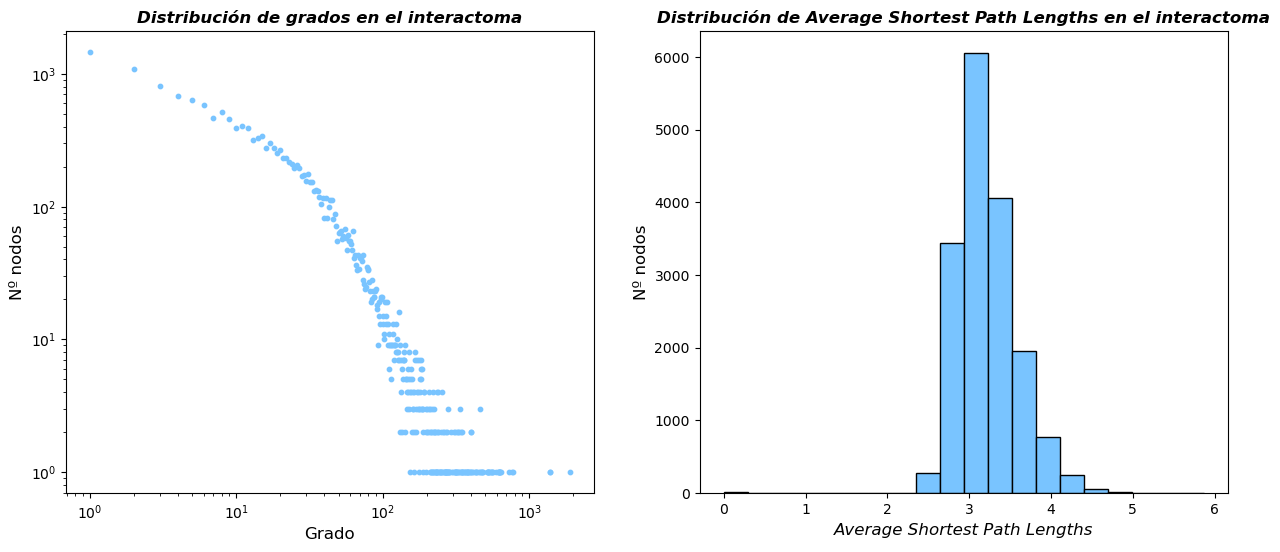

In [12]:
#Represento la distribución de degrees y Average SPLs

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

nodes = funciones_network_medicine.degrees_lista(G_ppi)[0]
degrees = funciones_network_medicine.degrees_lista(G_ppi)[1]
    
list_nodes_degree = pd.DataFrame(list(zip(nodes, degrees)), columns=['node','degree'])

#Agrupo la lista de nodos y degrees de la PPI en función del degree y cuento cuántos nodos de la red tienen ese degree    
G_plot_ppi = list_nodes_degree.groupby('degree').count()

 #Representación Distribución de Degrees de la PPI
axs[0].scatter(G_plot_ppi.index, G_plot_ppi['node'], marker='o', color='#79C4FF',s=10)
axs[0].set_yscale('log')
axs[0].set_xscale('log')
axs[0].set_xlabel('Grado', fontsize=12)
axs[0].set_ylabel('Nº nodos', fontsize=12)
axs[0].set_title('Distribución de grados en el interactoma', fontweight='bold', style='italic', fontsize=12)

#Representación de la distribución de Average SPL
axs[1].hist(ave_spl["AverageSPL"], bins=20, color='#79C4FF', edgecolor='black')
axs[1].set_xlabel('Average Shortest Path Lengths',style='italic', fontsize=12)
axs[1].set_ylabel('Nº nodos', fontsize=12)
axs[1].set_title('Distribución de Average Shortest Path Lengths en el interactoma', fontweight='bold', style='italic', fontsize=12)


In [ ]:
#Creo un archivo con los resultados para cada nodo

data = {'Nodo': nodes, 'Degree': degrees, 'Ave_SPL': [None] * len(nodes)}
#utilizo len(nodes) para que esas columnas tengan el mismo número de filas que el número total de nodos


# Asignar valores para los nodos no aislados
for i,nodo in enumerate(data["Nodo"]):
    for j,nodo2 in enumerate(ave_spl["Nodo"]):
        if nodo == nodo2:
            data['Ave_SPL'][i]=ave_spl["AverageSPL"][j]
# Crear DataFrame
df = pd.DataFrame(data)

# Guardar el DataFrame en un archivo CSV
df.to_csv('Datos_Gppi.csv', index=False)

### Enfermedades a estudiar

<div style="text-align: center;">
    
| Condition          | Concept ID |
|------------------- |------------|
| Dementia           | C0497327   |
| Bipolar Disorder   | C0005586   |
| Epilepsy           | C0014544   |
| Schizophrenia      | C0036341   |

</div>


#### Genes asociadas a cada enfermedad

In [6]:
gen_dementia = funciones_network_medicine.genes_enf("C0497327", dis_gen)
gen_epilepsy= funciones_network_medicine.genes_enf("C0014544", dis_gen)
gen_bipolar= funciones_network_medicine.genes_enf("C0005586", dis_gen)
gen_schizo = funciones_network_medicine.genes_enf("C0036341", dis_gen)

#### Asociación entre genes y proteínas

In [7]:
dict_dementia= funciones_network_medicine.pro_gen_dict(gen_dementia, gen_pro)
dict_epilepsy= funciones_network_medicine.pro_gen_dict(gen_epilepsy, gen_pro)
dict_bipolar= funciones_network_medicine.pro_gen_dict(gen_bipolar, gen_pro)
dict_schizo= funciones_network_medicine.pro_gen_dict(gen_schizo, gen_pro)

#### Genes en PPI

In [8]:
dict_dementia_PPI = funciones_network_medicine.gen_pro_PPI(dict_dementia, pro_pro)
dict_epilepsy_PPI = funciones_network_medicine.gen_pro_PPI(dict_epilepsy, pro_pro)
dict_bipolar_PPI = funciones_network_medicine.gen_pro_PPI(dict_bipolar, pro_pro)
dict_schizo_PPI = funciones_network_medicine.gen_pro_PPI(dict_schizo, pro_pro)

#### Genes en LCC

In [9]:
#Creo una subred a partir de las proteínas relacionadas con la enfermedad dentro de la PPI
SG_dementia= funciones_network_medicine.SG(dict_dementia_PPI, G_ppi)
SG_epilepsy= funciones_network_medicine.SG(dict_epilepsy_PPI, G_ppi)
SG_bipolar= funciones_network_medicine.SG(dict_bipolar_PPI, G_ppi)
SG_schizo= funciones_network_medicine.SG(dict_schizo_PPI, G_ppi)

In [10]:
#Calculo el LCC de cada subred (módulo de la enfermedad)
lcc_dementia= funciones_network_medicine.lcc(SG_dementia)
lcc_epilepsy= funciones_network_medicine.lcc(SG_epilepsy)
lcc_bipolar= funciones_network_medicine.lcc(SG_bipolar)
lcc_schizo= funciones_network_medicine.lcc(SG_schizo)

#### LCC randoms

In [11]:
lcc_ndp_dementia = funciones_network_medicine.lcc_simulation(SG_dementia, lcc_dementia, G_ppi, dp=False)
lcc_ndp_epilepsy = funciones_network_medicine.lcc_simulation(SG_epilepsy, lcc_epilepsy, G_ppi, dp=False)
lcc_ndp_bipolar = funciones_network_medicine.lcc_simulation(SG_bipolar, lcc_bipolar, G_ppi, dp=False)
lcc_ndp_schizo = funciones_network_medicine.lcc_simulation(SG_schizo, lcc_schizo, G_ppi, dp=False)

In [12]:
lcc_dp_dementia = funciones_network_medicine.lcc_simulation(SG_dementia, lcc_dementia, G_ppi, dp=True)
lcc_dp_epilepsy = funciones_network_medicine.lcc_simulation(SG_epilepsy, lcc_epilepsy, G_ppi, dp=True)
lcc_dp_bipolar = funciones_network_medicine.lcc_simulation(SG_bipolar, lcc_bipolar, G_ppi, dp=True)
lcc_dp_schizo = funciones_network_medicine.lcc_simulation(SG_schizo, lcc_schizo, G_ppi, dp=True)

#### Resultados

In [12]:
result = {
    "Nombre": ["Dementia", "Epilepsy", "Bipolar", "Schizophrenia"],
    "ID": ["C0497327", "C0014544", "C0005586", "C0036341"],
    "Nº genes totales asociados": [len(gen_dementia), len(gen_epilepsy), len(gen_bipolar), len(gen_schizo)],
    "Nº genes en PPI": [len(dict_dementia_PPI.values()), len(dict_epilepsy_PPI.values()), len(dict_bipolar_PPI.values()), len(dict_schizo_PPI.values())], 
    "Nº genes en LCC": [len(lcc_dementia), len(lcc_epilepsy), len(lcc_bipolar), len(lcc_schizo)],
    "Ratio de genes en LCC": [len(lcc_dementia)/len(dict_dementia_PPI.values()), len(lcc_epilepsy)/len(dict_epilepsy_PPI.values()), len(lcc_bipolar)/len(dict_bipolar_PPI.values()), len(lcc_schizo)/len(dict_schizo_PPI.values())],
    "Media del nº genes en random LCC (ndp)": [lcc_ndp_dementia[0], lcc_ndp_epilepsy[0], lcc_ndp_bipolar[0], lcc_ndp_schizo[0]],
    "Std del nº genes en random LCC (ndp)": [lcc_ndp_dementia[1], lcc_ndp_epilepsy[1], lcc_ndp_bipolar[1], lcc_ndp_schizo[1]],
    "Z-score (ndp)": [lcc_ndp_dementia[2], lcc_ndp_epilepsy[2], lcc_ndp_bipolar[2], lcc_ndp_schizo[2]],
     "Media del nº genes en random LCCs (dp)": [lcc_dp_dementia[0], lcc_dp_epilepsy[0], lcc_dp_bipolar[0], lcc_dp_schizo[0]],
    "Std del nº genes en random LCCs (dp)": [lcc_dp_dementia[1], lcc_dp_epilepsy[1], lcc_dp_bipolar[1], lcc_dp_schizo[1]], 
    "Z-score (dp)": [lcc_dp_dementia[2], lcc_dp_epilepsy[2], lcc_dp_bipolar[2], lcc_dp_schizo[2]]
}
result_tabla = pd.DataFrame(result)

In [13]:
result_tabla.head()

Nombre        ID  Nº genes totales asociados  Nº genes en PPI  \
0       Dementia  C0497327                         199              182   
1       Epilepsy  C0014544                         896              856   
2        Bipolar  C0005586                         608              549   
3  Schizophrenia  C0036341                        1369             1211   

   Nº genes en LCC  Ratio de genes en LCC  \
0              105               0.576923   
1              606               0.707944   
2              319               0.581056   
3              921               0.760528   

   Media del nº genes en random LCC (ndp)  \
0                                  11.339   
1                                 397.772   
2                                 173.336   
3                                 684.082   

   Std del nº genes en random LCC (ndp)  Z-score (ndp)  \
0                              7.656506      12.232865   
1                             32.395926       6.427598   
2                             31.923614       4.562892   
3                             32.884453       7.204559   

   Media del nº genes en random LCCs (dp)  \
0                                  76.066   
1                                 538.061   
2                                 271.911   
3                                 841.697   

   Std del nº genes en random LCCs (dp)  Z-score (dp)  
0                              6.882851      4.203781  
1                             14.034859      4.840732  
2                             11.307744      4.164314  
3                             14.292067      5.548742

### Representaciones para cada enfermedad

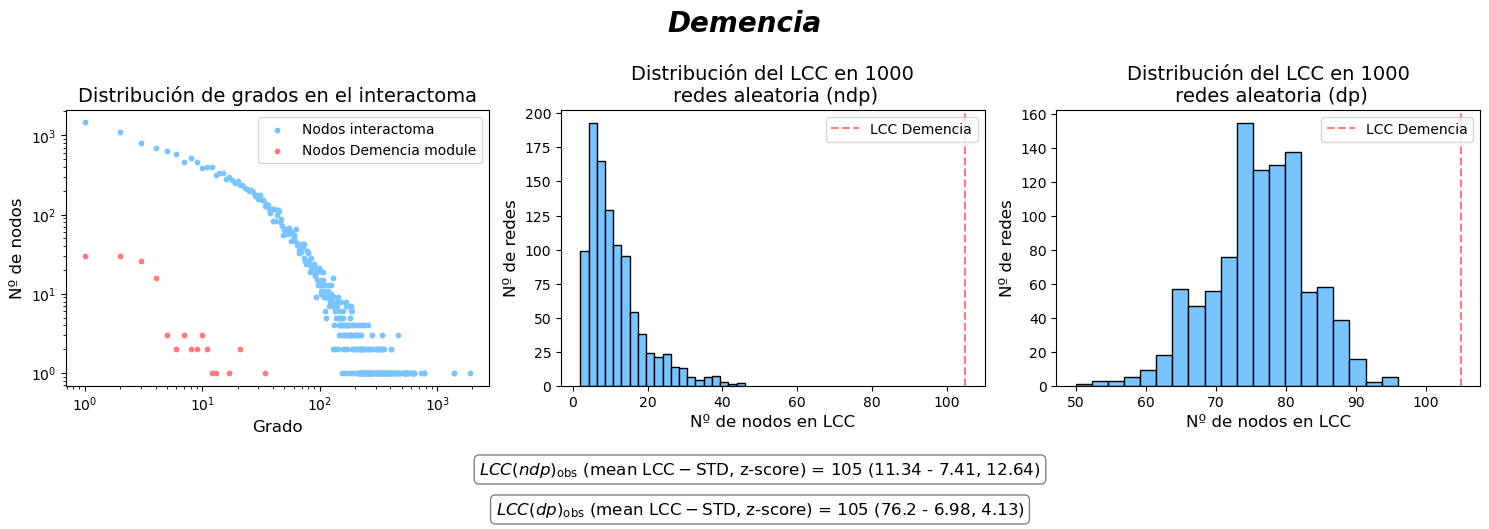

<Figure size 640x480 with 0 Axes>

In [13]:
funciones_network_medicine.rep("Demencia", SG_dementia, G_ppi, lcc_ndp_dementia[3], lcc_dp_dementia[3], lcc_dementia, lcc_ndp_dementia[0], lcc_ndp_dementia[1], lcc_ndp_dementia[2],lcc_dp_dementia[0], lcc_dp_dementia[1], lcc_dp_dementia[2])

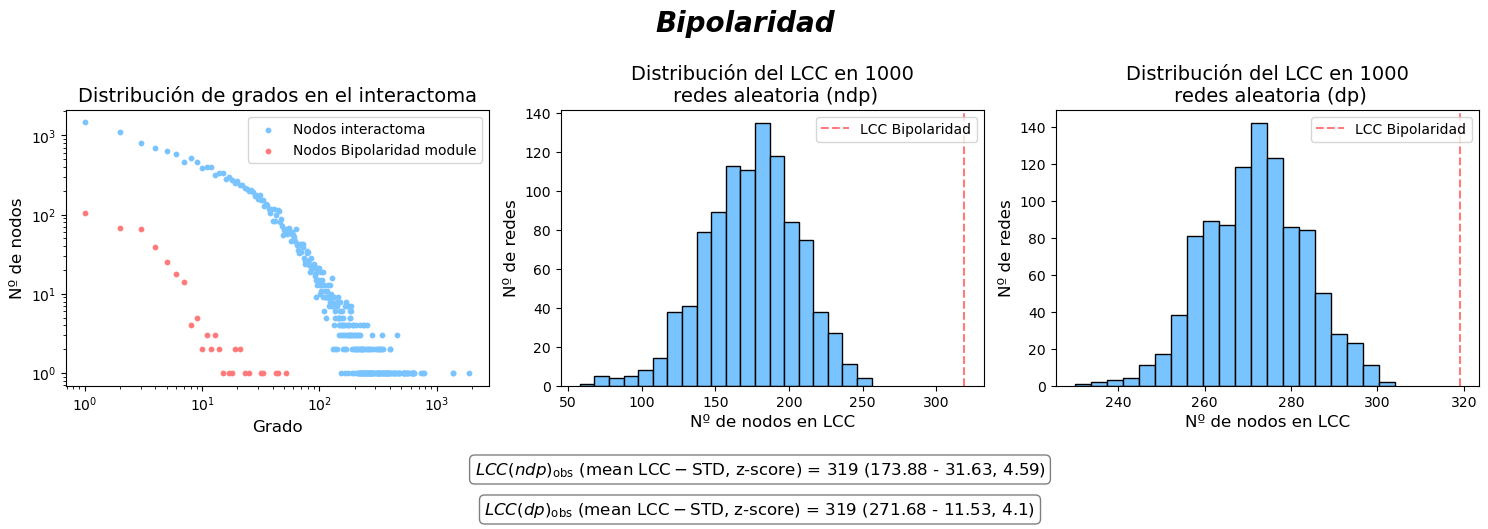

<Figure size 640x480 with 0 Axes>

In [ ]:
funciones_network_medicine.rep("Bipolaridad", SG_bipolar, G_ppi, lcc_ndp_bipolar[3], lcc_dp_bipolar[3], lcc_bipolar, lcc_ndp_bipolar[0], lcc_ndp_bipolar[1], lcc_ndp_bipolar[2],lcc_dp_bipolar[0], lcc_dp_bipolar[1], lcc_dp_bipolar[2])

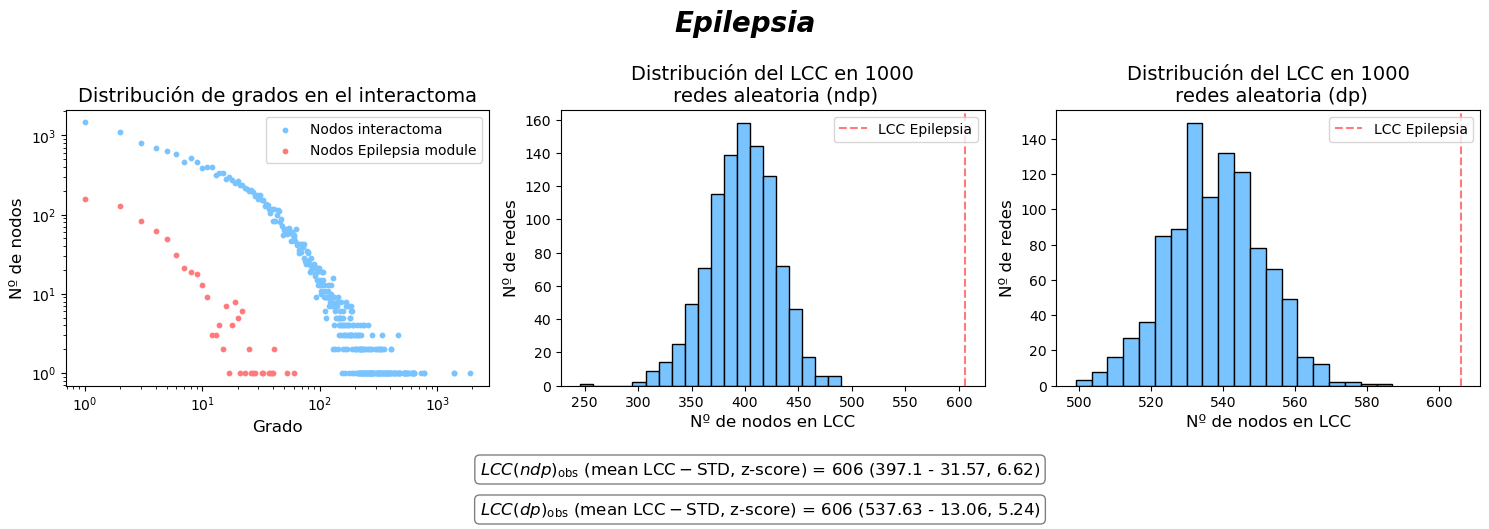

<Figure size 640x480 with 0 Axes>

In [15]:
funciones_network_medicine.rep("Epilepsia", SG_epilepsy, G_ppi, lcc_ndp_epilepsy[3], lcc_dp_epilepsy[3], lcc_epilepsy, lcc_ndp_epilepsy[0], lcc_ndp_epilepsy[1], lcc_ndp_epilepsy[2], lcc_dp_epilepsy[0], lcc_dp_epilepsy[1], lcc_dp_epilepsy[2])

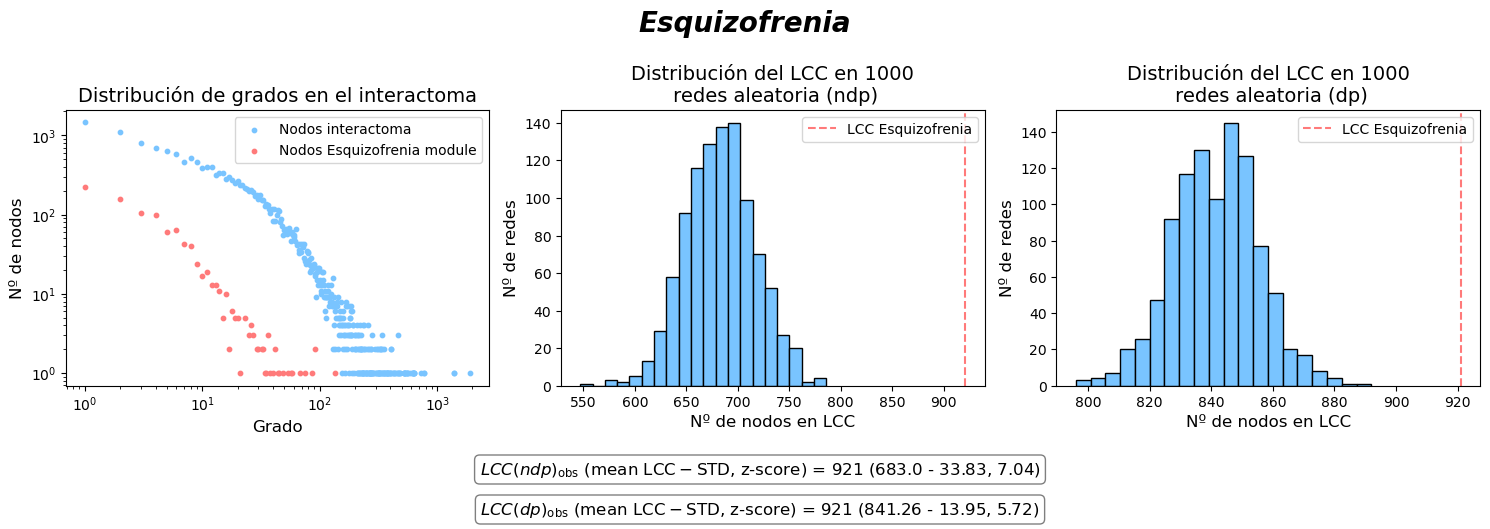

<Figure size 640x480 with 0 Axes>

In [16]:
funciones_network_medicine.rep("Esquizofrenia", SG_schizo, G_ppi, lcc_ndp_schizo[3], lcc_dp_schizo[3], lcc_schizo, lcc_ndp_schizo[0], lcc_ndp_schizo[1], lcc_ndp_schizo[2], lcc_dp_schizo[0], lcc_dp_schizo[1], lcc_dp_schizo[2])

### Visualización de módulos

In [10]:
#cargo los datos de los nodos en la red PPI
datos_gppi = pd.read_csv('Archivos/Datos_Gppi.csv', sep=",") 

In [13]:
#cargo los símbolos de los genes
sim = pd.read_csv('Archivos/protein_gene_symbol.csv', sep=",")

In [37]:
funciones_network_medicine.archivo_modulos("Demencia", lcc_dementia, datos_gppi, SG_dementia)

In [38]:
funciones_network_medicine.archivo_modulos("Bipolar", lcc_bipolar, datos_gppi, G_ppi)

In [39]:
funciones_network_medicine.archivo_modulos("Esquizofrenia", lcc_schizo, datos_gppi, G_ppi)

In [40]:
funciones_network_medicine.archivo_modulos("Epilepsia", lcc_epilepsy, datos_gppi, G_ppi)

### Representación del módulo de la demencia

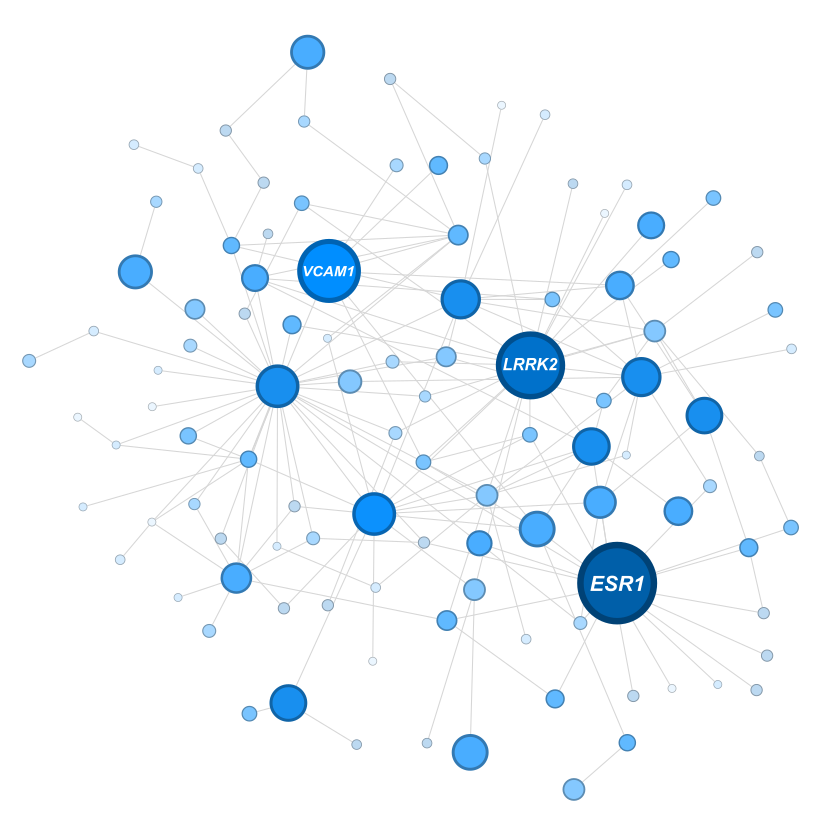

In [14]:
#Imagen realizada en gephi
Image(filename="Módulos/Módulo Demencia.png")

### Representación del módulo de la bipolaridad

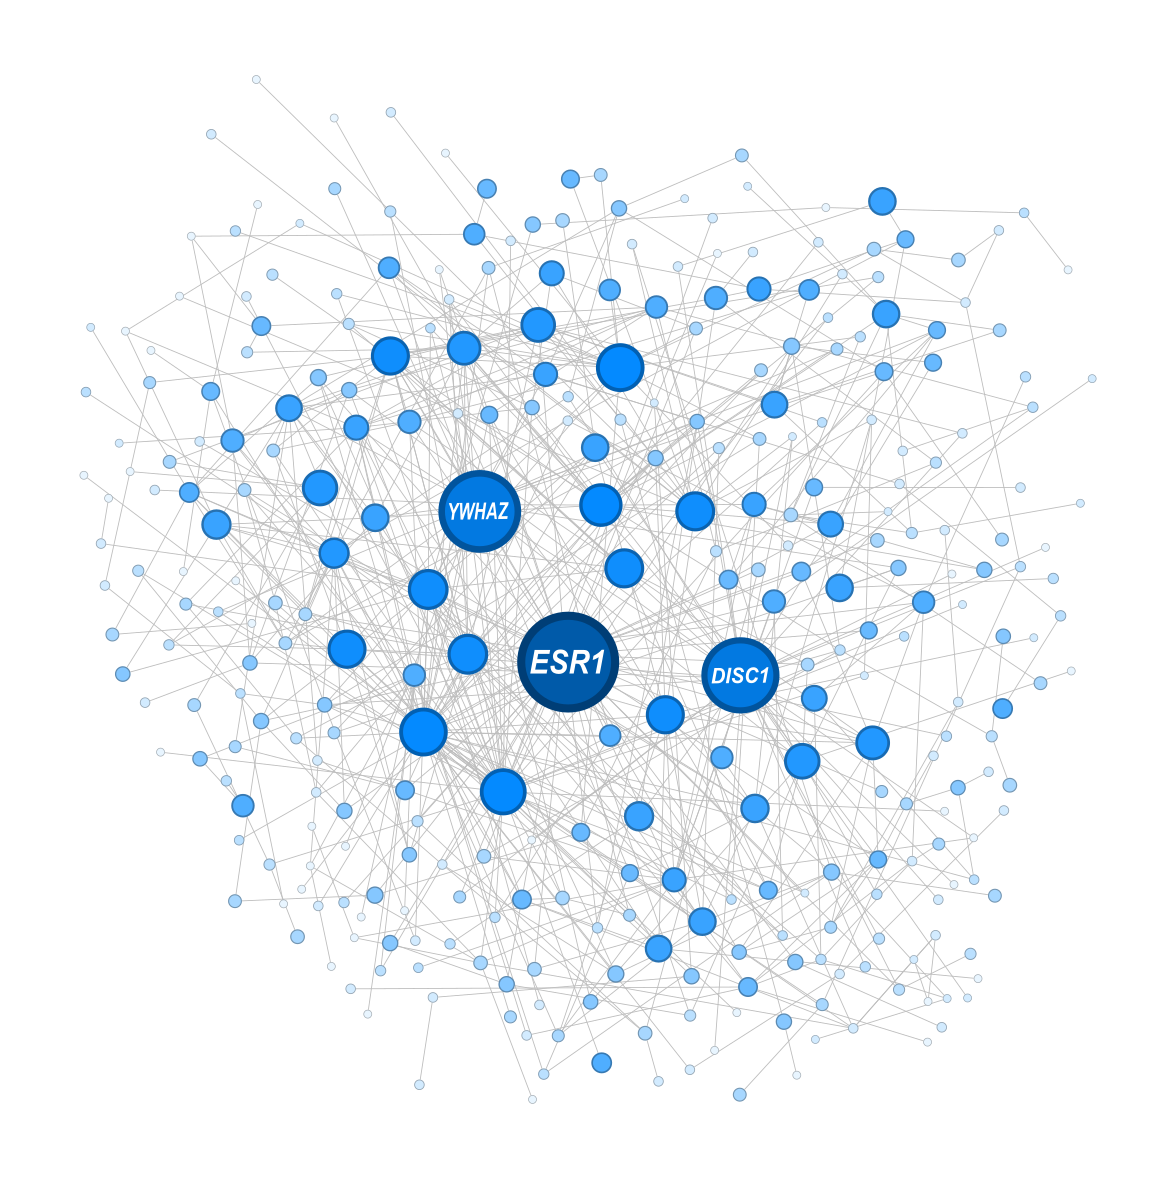

In [16]:
#Imagen realizada en gephi
Image(filename="Módulos/Módulo Bipolar.png")

### Representación del módulo de la epilepsia

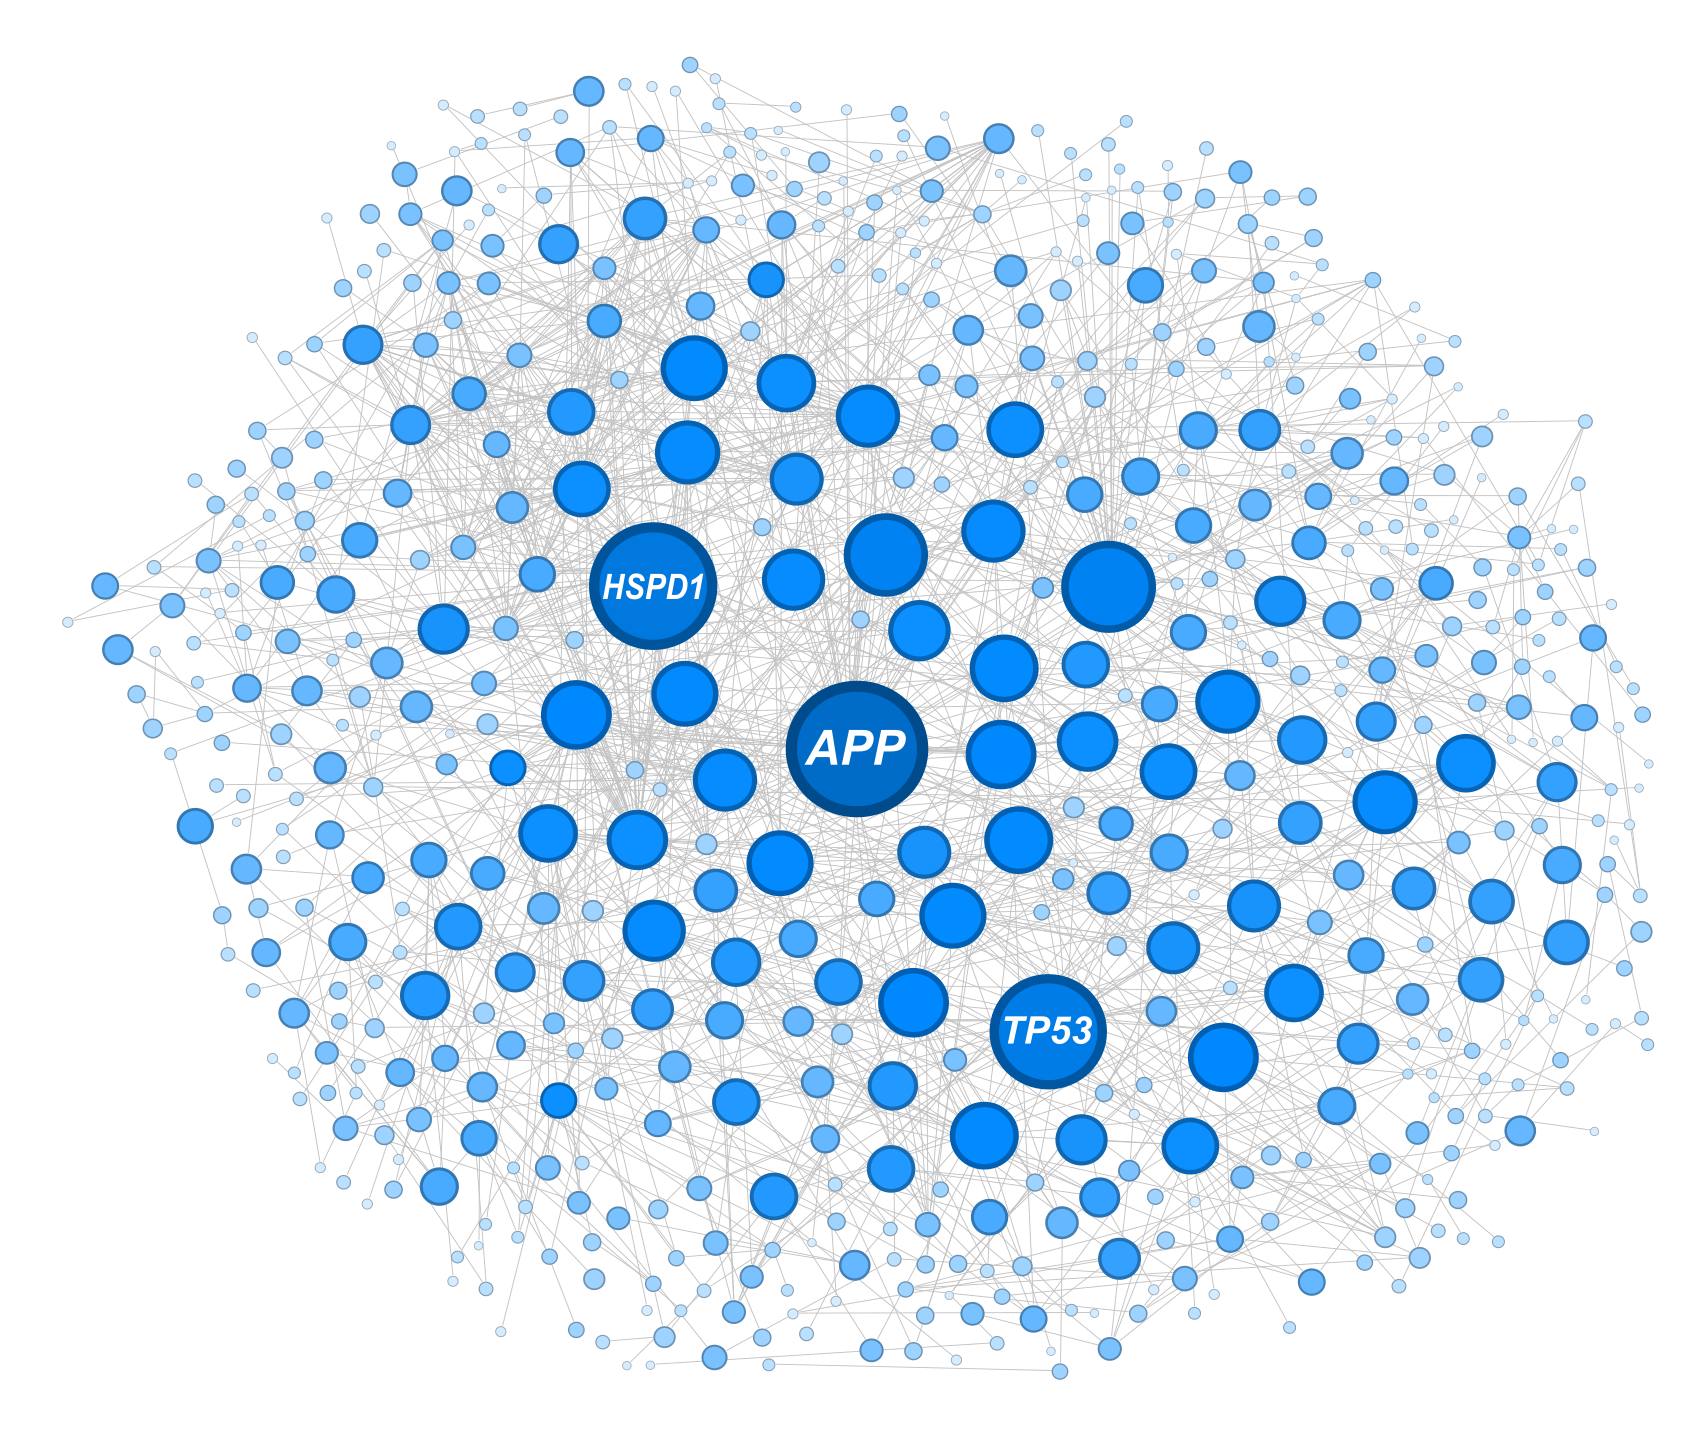

In [17]:
#Imagen realizada en gephi
Image(filename="Módulos/Módulo Epilepsia.png")

### Representación del módulo de la esquizofrenia

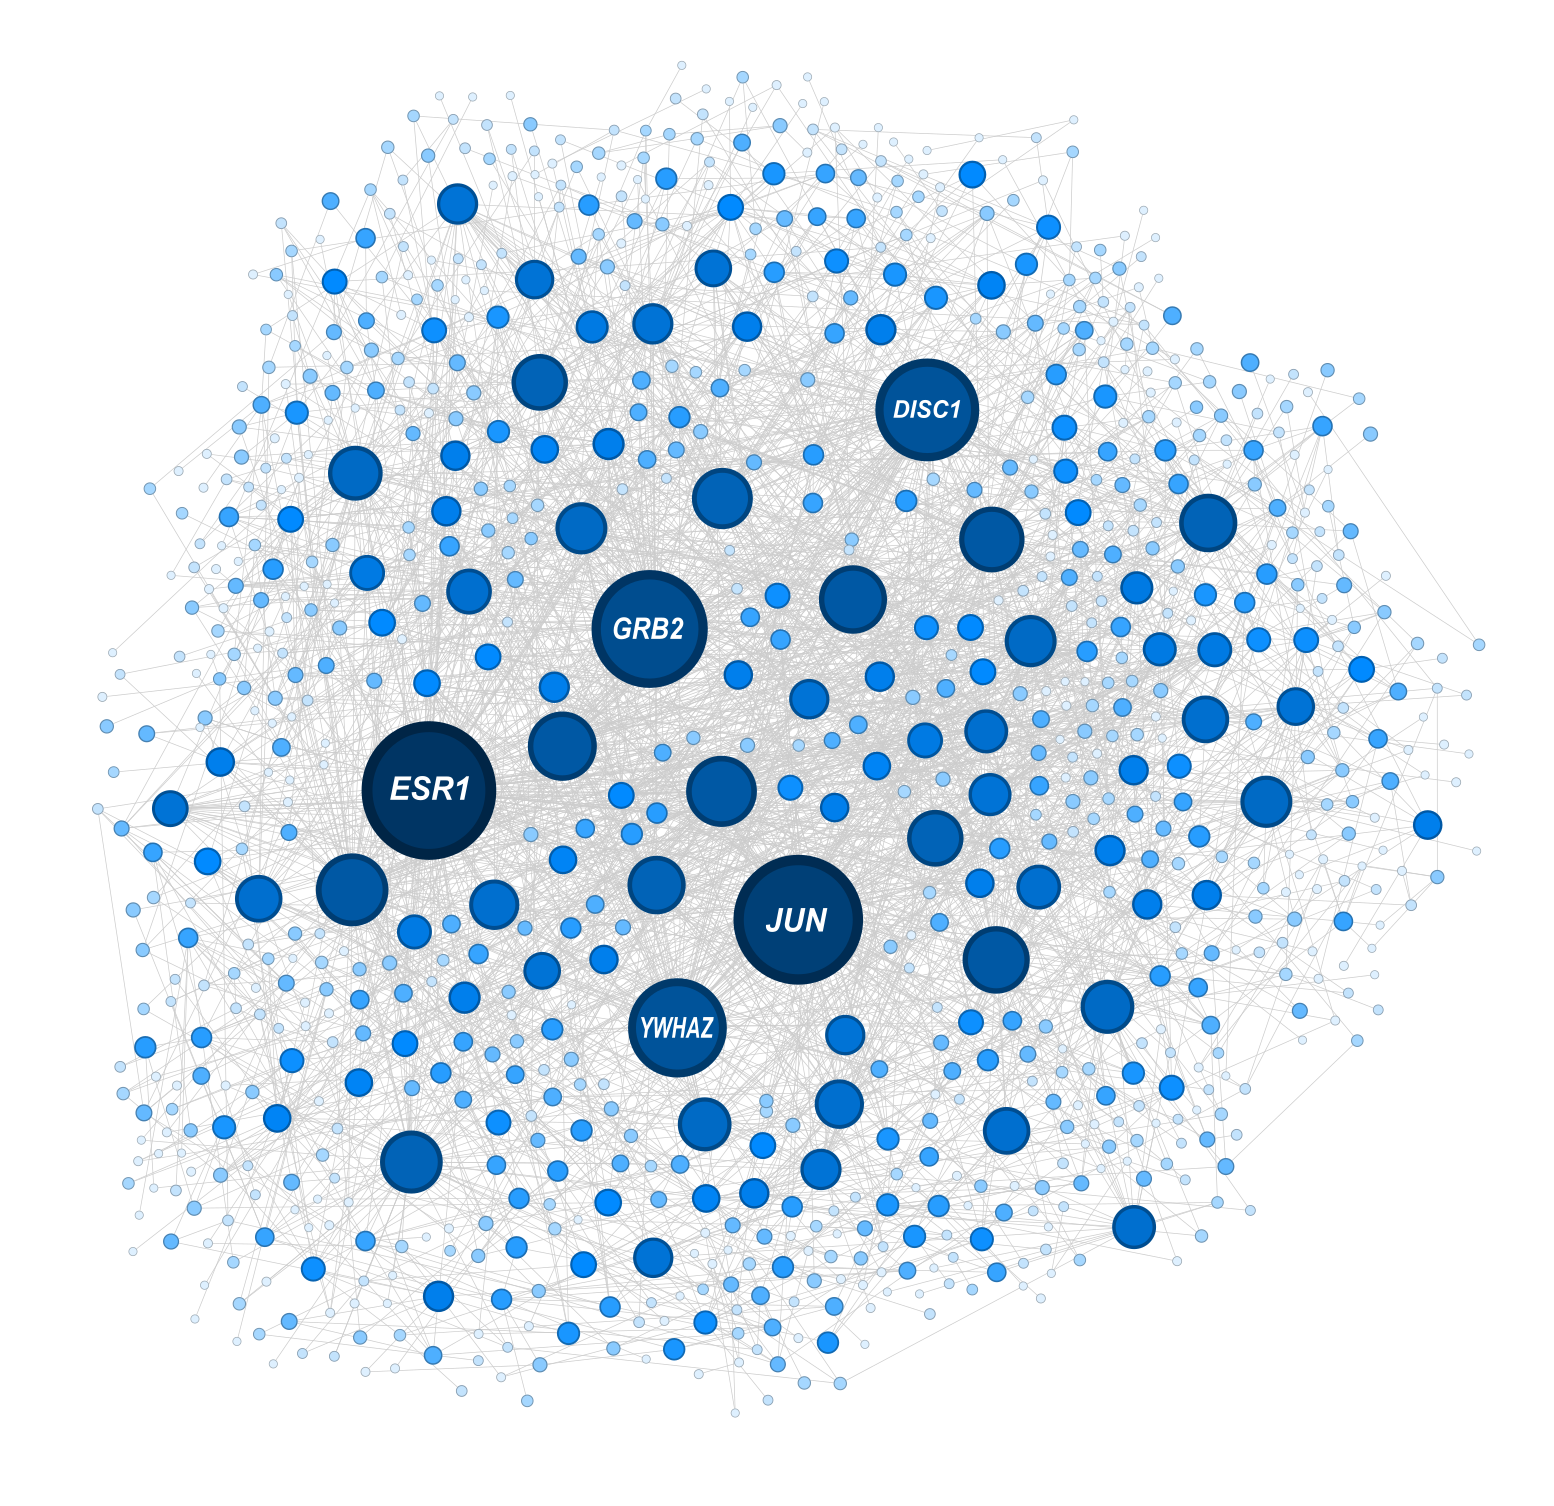

In [18]:
#Imagen realizada en gephi
Image(filename="Módulos/Módulo Esquizofrenia.png")

### Fármacos

In [4]:
drugs_dementia = funciones_network_medicine.drugs_enf("C0497327", dis_dru_the)
drugs_epilepsy= funciones_network_medicine.drugs_enf("C0014544", dis_dru_the)
drugs_bipolar= funciones_network_medicine.drugs_enf("C0005586", dis_dru_the)
drugs_schizo = funciones_network_medicine.drugs_enf("C0036341", dis_dru_the)

In [5]:
print("Fármacos demencia: " +str(len(drugs_dementia)))
print("Fármacos epilepsia: " +str(len(drugs_epilepsy)))
print("Fármacos bipolaridad: " +str(len(drugs_bipolar)))
print("Fármacos esquizofrenia: " +str(len(drugs_schizo)))

Fármacos demencia: 16
Fármacos epilepsia: 48
Fármacos bipolaridad: 78
Fármacos esquizofrenia: 71


### Targets

In [6]:
targets_dementia= funciones_network_medicine.targets(drugs_dementia, dru_pro)
targets_bipolar= funciones_network_medicine.targets(drugs_bipolar, dru_pro)
targets_epilepsy= funciones_network_medicine.targets(drugs_epilepsy, dru_pro)
targets_schizo= funciones_network_medicine.targets(drugs_schizo, dru_pro)

In [7]:
#Obtengo DataFrame con los fármacos totales y sus targets: 
lista_farmacos_total = set()
for farmaco in dru_pro["dru"]:
    if farmaco in set(dis_dru_the["dru"].values): #me quedo con los fármacos de los que tenemos info sobre a qué enfermedades tratan
        lista_farmacos_total.add(farmaco)
targets_total = funciones_network_medicine.targets(lista_farmacos_total, dru_pro)

### Proximidad enfermedad-fármaco

In [21]:
proximity_dementia_total = funciones_network_medicine.proximity(targets_total, spl, lcc_dementia, G_ppi)
proximity_bipolar_total = funciones_network_medicine.proximity(targets_total, spl, lcc_bipolar, G_ppi)
proximity_epilepsy_total = funciones_network_medicine.proximity(targets_total, spl, lcc_epilepsy, G_ppi)
proximity_schizo_total = funciones_network_medicine.proximity(targets_total, spl, lcc_schizo, G_ppi)

### Proximidad enfermedad-fármaco aleatoria

In [ ]:
proximity_dementia_rand = funciones_network_medicine.proximity_random(targets_total, spl, lcc_dementia, G_ppi, 1000)
proximity_dementia_rand.to_csv("Proximity random Demencia.csv", index = False)

In [ ]:
proximity_schizo_rand = funciones_network_medicine.proximity_random(targets_total, spl, lcc_schizo, G_ppi, 1000)
proximity_schizo_rand.to_csv("Proximity random Esquizofrenia.csv", index = False)

In [ ]:
proximity_bipolar_rand = funciones_network_medicine.proximity_random(targets_total, spl, lcc_bipolar, G_ppi, 1000)
proximity_bipolar_rand.to_csv("Proximity random Bipolaridad.csv", index = False)

In [ ]:
proximity_epilepsy_rand = funciones_network_medicine.proximity_random(targets_total, spl, lcc_epilepsy, G_ppi, 1000)
proximity_epilepsy_rand.to_csv("Proximity random Epilepsia.csv", index = False)

In [22]:
#cargo los archivos de proximidades aleatorias
proximity_dementia_rand= pd.read_csv('Archivos/Proximity random Demencia.csv', sep=",")
proximity_bipolar_rand= pd.read_csv('Archivos/Proximity random Bipolaridad.csv', sep=",")
proximity_epilepsy_rand= pd.read_csv('Archivos/Proximity random Epilepsia.csv', sep=",")
proximity_schizo_rand= pd.read_csv('Archivos/Proximity random Esquizofrenia.csv', sep=",")

#### Archivo resultados proximidad

In [17]:
enfermedades = ['Demencia', 'Bipolaridad', 'Epilepsia', 'Esquizofrenia']
farmacos = set(dis_dru_the["dru"].values) & set(dru_pro["dru"].values)

# Diccionario con los Dataframes de proximidad observada y aleatoria de cada enfermedad
proximity_df = {
    'Demencia': proximity_dementia_total,
    'Bipolaridad': proximity_bipolar_total,
    'Epilepsia': proximity_epilepsy_total,
    'Esquizofrenia': proximity_schizo_total
}

proximity_random_df = {
    'Demencia': proximity_dementia_rand,
    'Bipolaridad': proximity_bipolar_rand,
    'Epilepsia': proximity_epilepsy_rand,
    'Esquizofrenia': proximity_schizo_rand
}

#archivo resultados con: Enfermedades, Fármacos, Tratamiento, dc, dc_mean, dc_std, dc_zscore
resultado_combinado = funciones_network_medicine.combinar_proximidades(enfermedades, farmacos, proximity_df, proximity_random_df, dis_dru_the)
resultado_combinado.to_csv("Resultados proximidad.csv", index = False)

In [5]:
#cargo el archivo
resultado_proximidad= pd.read_csv('Archivos/Resultados proximidad.csv', sep=",")

### Representación proximidades

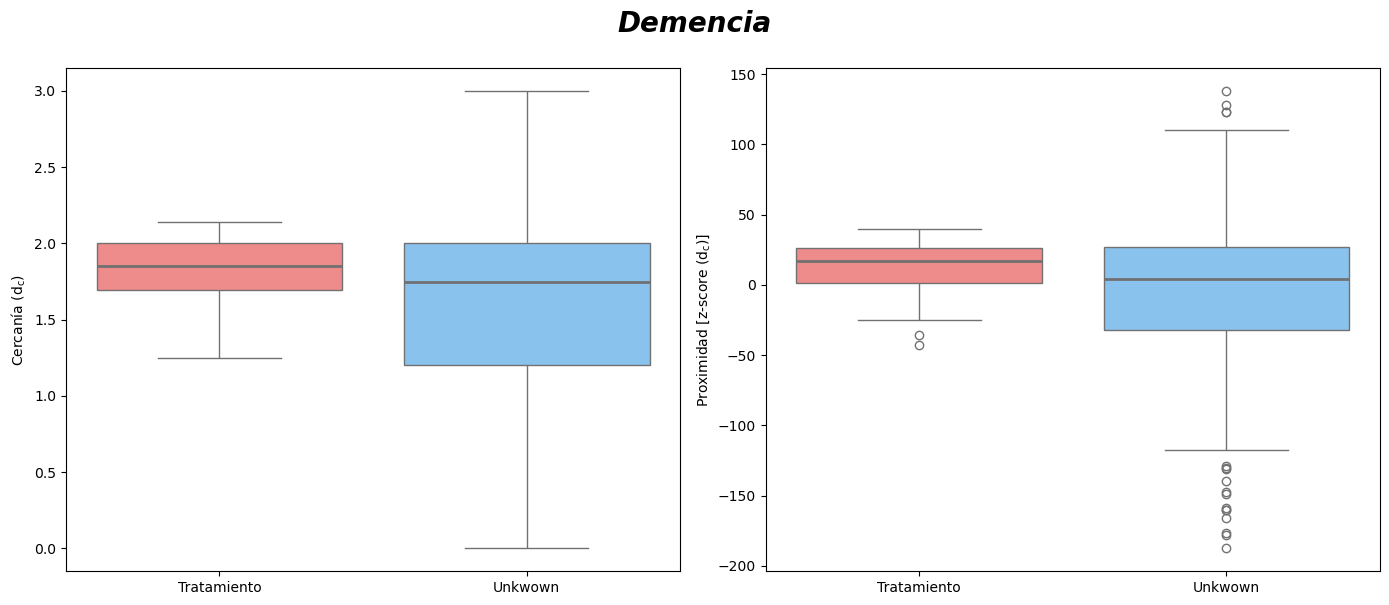

In [6]:
funciones_network_medicine.rep_prox(resultado_proximidad, "Demencia") 

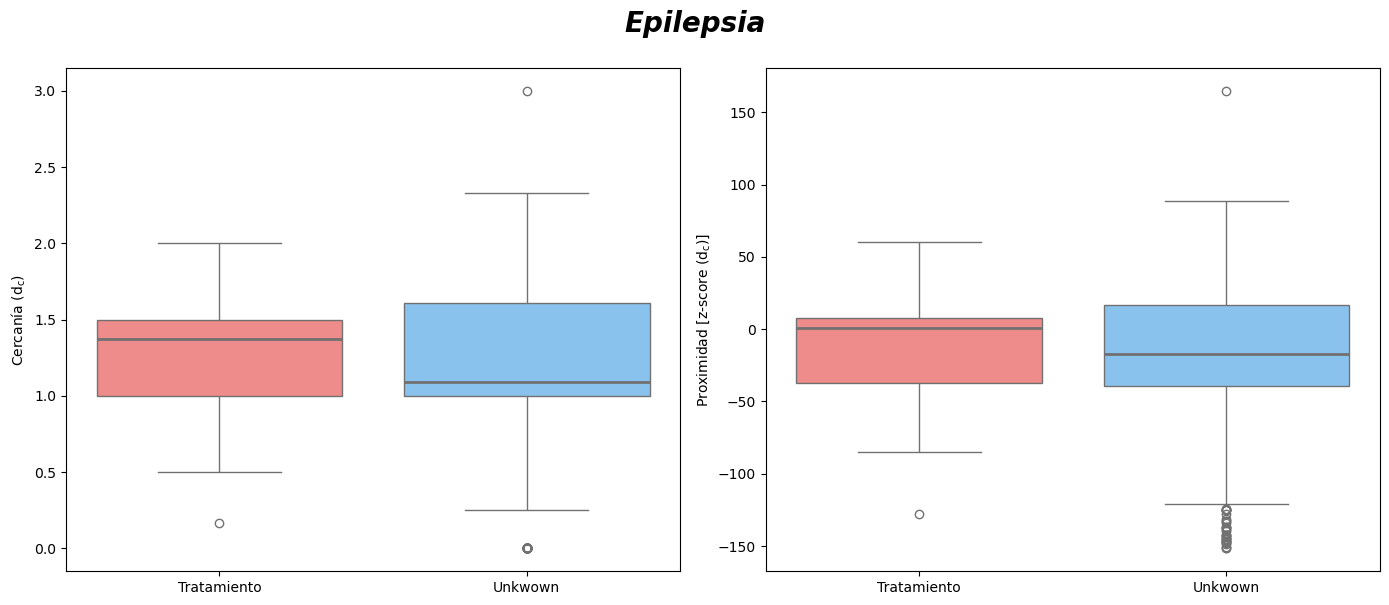

In [7]:
#Epilepsia
funciones_network_medicine.rep_prox(resultado_proximidad, "Epilepsia")

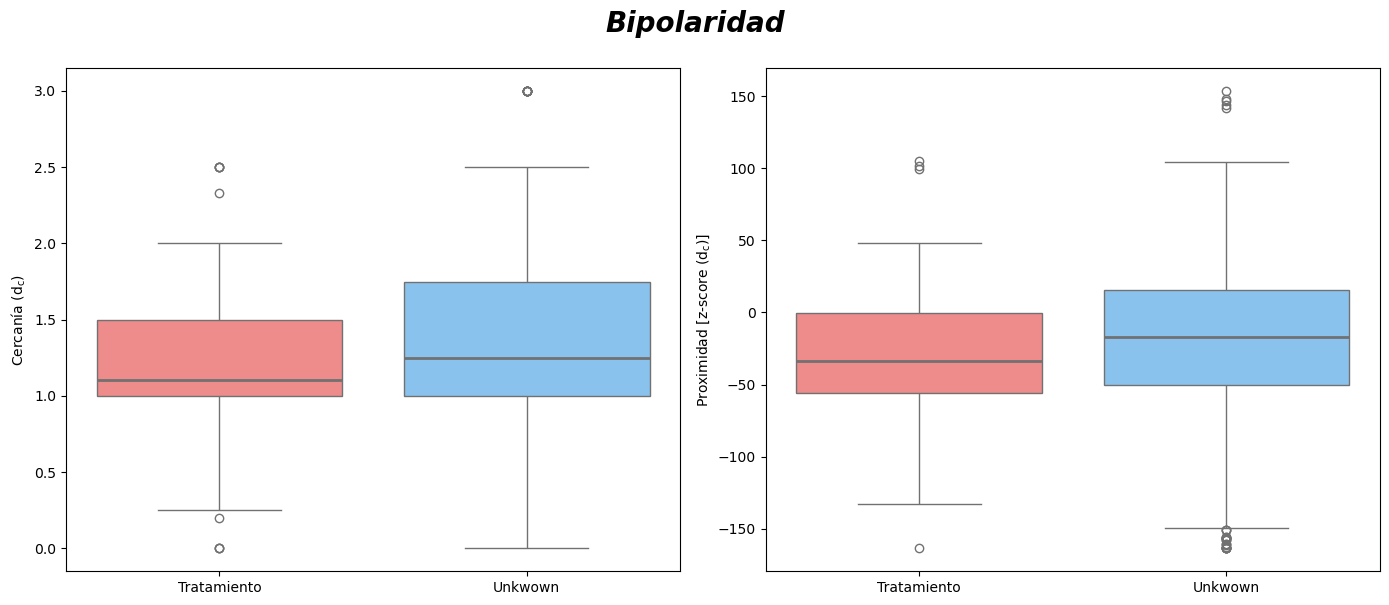

In [8]:
#Bipolaridad
funciones_network_medicine.rep_prox(resultado_proximidad, "Bipolaridad") 

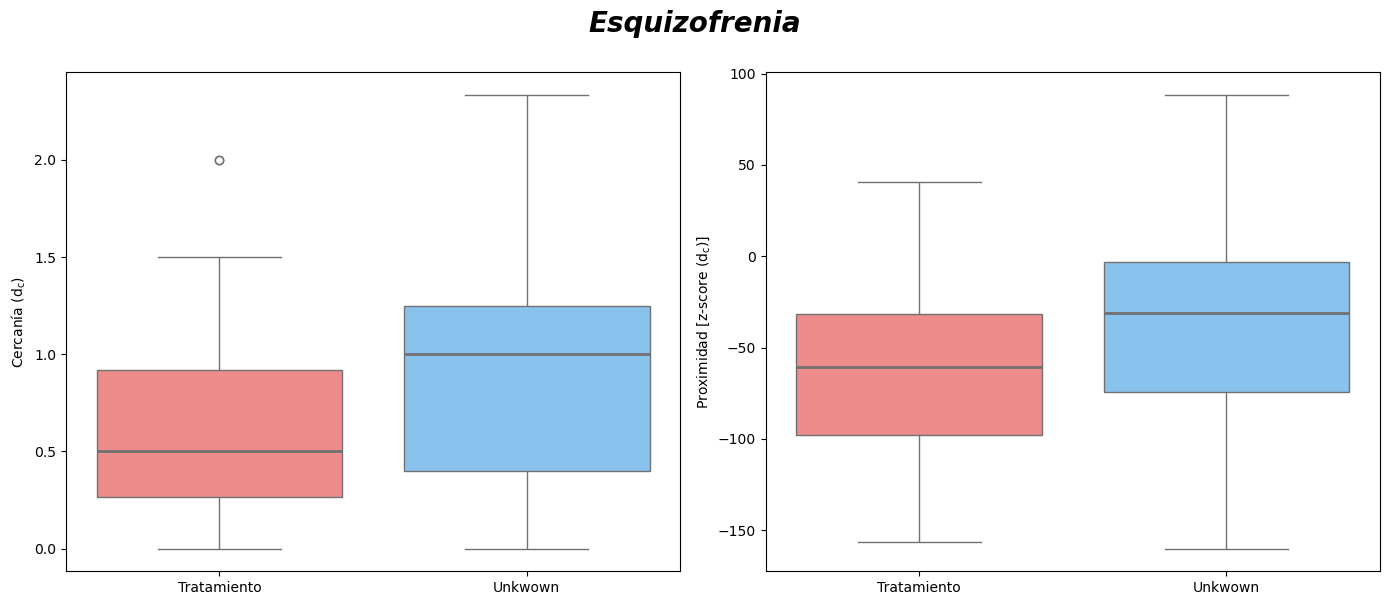

In [9]:
#Esquizofrenia
funciones_network_medicine.rep_prox(resultado_proximidad, "Esquizofrenia") 

In [39]:
lcc_df = {
    'Demencia': lcc_dementia,
    'Bipolaridad': lcc_bipolar,
    'Epilepsia': lcc_epilepsy,
    'Esquizofrenia': lcc_schizo
}

#obtengo un archivo a partir del DataFrame con los resultados de la proximidad que incluya una columna que indique si los fármacos
#presentan una proteína diana dentro del módulo de cada enfermedad estudiada
resultados_proximidad_targets = funciones_network_medicine.targets_modulo(resultado_proximidad, targets_total, lcc_df)
resultados_proximidad_targets.to_csv("Resultados proximidad y targets en módulo.csv", index = False)

In [18]:
#cargo el archivo obtenido en la celda anterior
resultados_proximidad_targets = pd.read_csv('Archivos/Resultados proximidad y targets en módulo.csv', sep=",")

In [21]:
candidatos_dementia = funciones_network_medicine.farmacos_candidatos(resultados_proximidad_targets, "Demencia", dis_dru_the)
candidatos_bipolar = funciones_network_medicine.farmacos_candidatos(resultados_proximidad_targets, "Bipolaridad", dis_dru_the)
candidatos_epilepsy = funciones_network_medicine.farmacos_candidatos(resultados_proximidad_targets, "Epilepsia", dis_dru_the)
candidatos_schizo = funciones_network_medicine.farmacos_candidatos(resultados_proximidad_targets, "Esquizofrenia", dis_dru_the)

In [66]:
enfermedades = ['Demencia', 'Bipolaridad', 'Epilepsia', 'Esquizofrenia']

df_resultados_candidatos = pd.DataFrame()

# Itero sobre las cuatro enfermedades
for enfermedad in enfermedades:
    # Utilizo la función farmacos_candidatos para cada enfermedad neurológica y concateno los resultados
    resultados_enfermedad = farmacos_candidatos(resultados_proximidad_targets, enfermedad, dis_dru_the)
    df_resultados_candidatos = pd.concat([df_resultados_candidatos, resultados_enfermedad], ignore_index=True)

df_resultados_candidatos.to_csv("Fármacos y enfermedades candidatos de reposicionamiento.csv", index = False)